In [1]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime, timedelta


def read_data(fname='all'):
    freq = '19230U'   # ~19ms, using sampling frequency is 52samples/sec
    dt = datetime.now()
    data = pd.DataFrame()
    
    if fname == 'all':    # read all files
        data_files = []
        
        for f_id in range(1,16):
            data = pd.read_csv('data/%d.csv' %f_id, 
                               names=['id', 'x', 'y', 'z', 'label'], 
                               header=None, index_col=0)
            data.index = pd.date_range(start=dt, periods=data.shape[0], freq=freq)
            dt += timedelta(hours=3)
            data_files.append(data)
            
        data = pd.concat(data_files)
    
    else:    # read one file only
        data = pd.read_csv('data/%s.csv' %fname, 
                   names=['id', 'x', 'y', 'z', 'label'], 
                   header=None, index_col=0)

        data.index = pd.date_range(start='00:00:00', periods=data.shape[0], freq=freq)
        
    # Filter and clean data
    data = data.dropna()
    data = data[data['label'] != 0]   # some rows are misclassified as 0
        
    return data

### Feature extraction.
Segment the data using sliding window of size 10s, and from each window extract the common features (mean, standard deviation, variance), and some other features used specifically for Human Activity Recognition like RMS (Root Mean Square), magnitude of acceleration, and pairwise correlation between x, y, z.

In [2]:
from scipy.stats import mode 

def rms(ts): return np.sqrt(np.mean(ts**2))

def corr(df): 
    cor = df.corr()
    return pd.DataFrame({'xy':[cor['x']['y']], 'xz':[cor['x']['z']], 'yz':[cor['y']['z']]})

def get_features(data, wsize='10s', f_list=['mean', 'std', 'var', rms]):
    # f_list is a list of features names or methods to apply in resampling
    
    # features that invlove one dimension only.
    fname = '_' + (f_list[0] if isinstance(f_list[0], str) else f_list[0].__name__)   
    feats = data[['x','y','z']].resample(wsize, how=f_list[0]).add_suffix(fname)
    
    for i, f in enumerate(f_list[1:]):
        fname = '_' + (f if isinstance(f, str) else f.__name__)
        feat = data[['x','y','z']].resample(wsize, how=f).add_suffix(fname)
        feats = feats.join(feat)   

    # features that involve more than one dimension.                                               
    mean_mag = (data**2).sum(axis=1).resample(wsize, how=lambda ts: np.sqrt(ts).mean())
    mean_mag.name = 'mean_mag'
    feats = feats.join(mean_mag) 

    pairs_cor = data.groupby(pd.TimeGrouper(wsize)).apply(corr).reset_index(1, drop=True)
    feats = feats.join(pairs_cor) 
    
    y = data['label'].resample(wsize, how=lambda ts: mode(ts)[0] if ts.shape[0] > 0 else np.nan)   

    # drop any nan values
    mask = np.any(np.isnan(feats), axis=1)
    feats, y = feats[~mask], y[~mask]
    mask = np.isnan(y)
    feats, y = feats[~mask], y[~mask]
    
    return (feats, y)


### Choosing and tuning the model.

Splitting data (after feature extraction) into train and test subsets. Using grid search on the training set each model is trained and tuned, the the models are compared according to their performance on the test set using accuracy and AUC (Area Under ROC Curve).

Best score: 0.822006472492
Best params: {'n_estimators': 50}
Accuracy score on the test set: 0.824
Best score: 0.803667745415
Best params: {'n_estimators': 400, 'learning_rate': 0.1, 'max_depth': 3}
Accuracy score on the test set: 0.824
Best score: 0.639338367494
Best params: {'n_estimators': 200, 'learning_rate': 0.1}
Accuracy score on the test set: 0.620
Best score: 0.783531103919
Best params: {'voting': 'soft'}
Accuracy score on the test set: 0.800


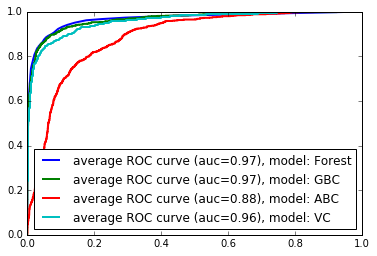

In [26]:
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,
AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

def train_model(X, y, est, grid):
    gs = GridSearchCV(estimator=est, param_grid=grid, scoring='accuracy', cv=5, n_jobs=-1)
    gs = gs.fit(X, y)
    print 'Best params:', gs.best_params_  
    
    return (gs.best_estimator_, gs.best_params_)


def eval_model(mod, X_test, y_test, mod_name):
    y_prob = mod.predict_proba(X_test)
    y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4, 5, 6, 7])
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2,
             label='average ROC curve (auc=%0.2f), model: %s' % (roc_auc,mod_name))
    plt.legend(loc="lower right")
    
    y_pred = mod.predict(X_test)
    score = accuracy_score(y_true=y_test, y_pred=y_pred)
    print 'Accuracy score on the test set: %.3f' %score
    
    confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print 'Confusion Matrix...'
    print confmat


data = read_data('1')
param_range = [0.0001, 0.001, 0.01, 0.1]

feats, y = get_features(data, wsize='10s')
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(feats, y, test_size=.25, random_state=0, stratify=y)


# Support Vector Machine
'''model, params = train_model(X_train, y_train, 
                    est=SVC(probability=True),
                    #grid=[{'C': param_range[:1], 'degree': [2], 'kernel': ['poly']}])
                    grid={'C': param_range[:1], 'gamma': param_range[:1], 'kernel': ['linear']})
eval_model(model, X_test, y_test, 'SVC')
              
# Decision Tree
model, params = train_model(X_train, y_train, 
                    est=DecisionTreeClassifier(criterion='entropy'),
                    grid={'max_depth':[2,3,4,5 ]})
eval_model(model, X_test, y_test, 'Tree')'''

# Random Forest
model, params = train_model(X_train, y_train, 
                    est=RandomForestClassifier(n_jobs=-1, criterion='entropy'),
                    grid={'n_estimators':[50, 100, 200]})
eval_model(model, X_test, y_test,'Forest')

# Gradient Boosting
model, params = train_model(X_train, y_train, 
                    est=GradientBoostingClassifier(learning_rate=1.0, random_state=0),
                    grid={'n_estimators':[50, 200, 400], 'max_depth':[1,2,3],
                          'learning_rate':[.1,.05,.01,.005]})
eval_model(model, X_test, y_test,'GBC')

# Ada Boosting
model, params = train_model(X_train, y_train, 
                    est=AdaBoostClassifier(),
                    grid={'n_estimators':[50, 200, 400], 'learning_rate':[.1,.05,.01,.005]})
eval_model(model, X_test, y_test,'ABC')

'''model, params = train_model(X_train, y_train, 
                    est=KNeighborsClassifier(),
                    grid={'n_neighbors':[5, 8, 10], 'weights':['uniform', 'distance']})
eval_model(model, X_test, y_test,'KNN')
'''

#
model, params = train_model(X_train, y_train, 
                    est=VotingClassifier(estimators=[
                            ('ABC', AdaBoostClassifier(n_estimators=50, learning_rate=.05)),
                            ('GBC', GradientBoostingClassifier(learning_rate=.1, n_estimators=50, max_depth=2)),
                            ('FC', RandomForestClassifier(criterion='entropy', n_jobs=-1, n_estimators=50))
                                                    ]),
                    grid={'voting':['soft']})
eval_model(model, X_test, y_test,'VC')


### Trying different windows sizes.

The choice of a window size of ... was quite arbitrary, in the research papers on HAR different window sizes were used that range from 1 sec to 20 sec.
Also types of windows are used in the field, disjoint and overlapping. get_features2 defines the same features defined before but using rolling window taking only values at overlapping of 50%.

In [ ]:
def get_features2(data, wsize_sec):
    wsize = 52 * wsize_sec   # sampling frequency/sec * length of window in seconds
    feats = pd.rolling_mean(data[['x','y','z']], wsize, wsize/2).add_suffix('_mean')
    
    feat = pd.rolling_std(data[['x','y','z']], wsize, wsize/2).add_suffix('_std')
    feats = feats.join(feat)
    
    feat = pd.rolling_var(data[['x','y','z']], wsize, wsize/2).add_suffix('_var')
    feats = feats.join(feat)
    
    feat = pd.rolling_apply(data[['x','y','z']], wsize, rms, wsize/2).add_suffix('_rms')
    feats = feats.join(feat)
        
    mean_mag = pd.rolling_apply((data**2).sum(axis=1), wsize, lambda ts: np.sqrt(ts).mean(), wsize/2)
    mean_mag.name = 'mean_mag'
    feats = feats.join(mean_mag) 

    xy_cor = pd.rolling_corr(data['x'], data['y'], wsize, wsize/2)
    xy_cor.name = 'xy'
    xz_cor = pd.rolling_corr(data['x'], data['z'], wsize, wsize/2)
    xz_cor.name = 'xz'
    yz_cor = pd.rolling_corr(data['y'], data['z'], wsize, wsize/2)
    yz_cor.name = 'yz'
    feats = feats.join(xy_cor).join(xz_cor).join(yz_cor)
    
    # take the most frequent label in each window
    y = pd.rolling_apply(data['label'], wsize, lambda ts: mode(ts)[0], wsize/2)   
    feats = feats.iloc[wsize/2::wsize/2]
    y = y.iloc[wsize/2::wsize/2]
    
    return feats, y


win_sizes = ['2','3', '5', '7', '10', '15', '20']
best_model = RandomForestClassifier(criterion='entropy', n_jobs=-1, n_estimators=50)

for wsize in win_sizes:
    print 'Window Size: %s' % wsize
    
    # disjoint window
    feats, y = get_features(data, wsize=wsize + 's')
    X_train, X_test, y_train, y_test = train_test_split(feats, y, test_size=.25,
                                                        random_state=0, stratify=y)
    best_model.fit(X_train, y_train)
    eval_model(best_model, X_test, y_test,'%ss - nonoverlapping' %wsize)

    
    # overlapping window
    feats, y = get_features2(data, int(wsize))
    X_train, X_test, y_train, y_test = train_test_split(feats, y, test_size=.25,
                                                        random_state=0, stratify=y)
    best_model.fit(X_train, y_train)
    eval_model(best_model, X_test, y_test,'%ss - overlapping' %wsize)

    

### Testing models on multi-subject data.

In [46]:
best_model = RandomForestClassifier(criterion='entropy', n_jobs=-1, n_estimators=50)
data_all = read_data('all') 
feats, y = get_features2(data, wsize='10s')
X_train, X_test, y_train, y_test = train_test_split(feats_norm, y, test_size=.25,
                                                    random_state=0, stratify=y)
best_model.fit(X_train, y_train)
eval_model(best_model, X_test, y_test,'%ss - nonoverlapping' %wsize)


### Try detecting and removing outliers.

In [ ]:
from sklearn import svm

clf = svm.OneClassSVM(kernel="linear", nu=.25, gamma=.001)
clf.fit(feats)

ol_pred = clf.predict(feats)

mask = (ol_pred==1)
feats2, y2 = feats[mask], y[mask]
X_train, X_test, y_train, y_test = train_test_split(feats2, y2, test_size=.25,
                                                    random_state=0, stratify=y)
best_model.fit(X_train, y_train)
eval_model(best_model, X_test, y_test,'..')


### Try normalization.

In [ ]:
from sklearn.preprocessing import normalize

feats_norm = normalize(feats, axis=0)
X_train, X_test, y_train, y_test = train_test_split(feats_norm, y, test_size=.25,
                                                    random_state=0, stratify=y)
best_model.fit(X_train, y_train)
eval_model(best_model, X_test, y_test,'...')
